In [2]:
#To import all required modules for HW3
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.metrics.pairwise import euclidean_distances
import scipy.io
import numpy as np
import pandas as pd 
from glob import glob
import cv2
import pickle
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
import seaborn as sns

%matplotlib inline

In [3]:
#To Load features extracted using VGG16 using pickle 
# open a files, where I stored the pickled data
file1 = open('vgg16_features/final_conv_X_train_feature_list.pkl', 'rb')
file2 = open('vgg16_features/final_conv_X_valid_feature_list.pkl', 'rb')
file3 = open('vgg16_features/final_conv_X_test_feature_list.pkl', 'rb')
file4 = open('vgg16_features/final_conv_y_train_feature_list.pkl', 'rb')
file5 = open('vgg16_features/final_conv_y_vallid_feature_list.pkl', 'rb')
file6 = open('vgg16_features/final_conv_y_test_feature_list.pkl', 'rb')

# dump information 
X_train = pickle.load(file1)
X_valid = pickle.load(file2)
X_test = pickle.load(file3)

y_train = pickle.load(file4)
y_valid = pickle.load(file5)
y_test = pickle.load(file6)

# close the file
file1.close()
file2.close()
file3.close()
file4.close()
file5.close()
file6.close()

#array 


In [4]:
#To convert features list into an array reshape into 1,49,512
X_train_data = np.asarray(X_train).reshape(7500,512 * 49)
X_valid_data = np.asarray(X_valid).reshape(1500,512 * 49)
X_test_data = np.asarray(X_test).reshape(1500,512 * 49)

y_train_data = np.asarray(y_train).reshape(7500,15)
y_valid_data = np.asarray(y_valid).reshape(1500,15)
y_test_data = np.asarray(y_test).reshape(1500,15)

#To print arrays shape
print("X_train shape: ", X_train_data.shape)
print("X_valid shape: ", X_valid_data.shape)
print("X_test shape: ", X_test_data.shape)

print("y_train shape: ", y_train_data.shape)
print("y_valid shape: ", y_valid_data.shape)
print("y_test shape: ", y_test_data.shape)


X_train shape:  (7500, 25088)
X_valid shape:  (1500, 25088)
X_test shape:  (1500, 25088)
y_train shape:  (7500, 15)
y_valid shape:  (1500, 15)
y_test shape:  (1500, 15)


In [5]:
#To encode label 
y_train_data_new = []
y_valid_data_new = []
y_test_data_new = []

def invert_label(label_array):
    newlist = []
    dataset_label = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
    values = np.asarray(dataset_label)
    # integer encode
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(values)
    for l in label_array:
        inverted = label_encoder.inverse_transform([argmax(l)])
        newlist.append(inverted)
    return newlist

y_train_data_new.append(invert_label(y_train_data))
y_valid_data_new.append(invert_label(y_valid_data))
y_test_data_new.append(invert_label(y_test_data))


y_train_label = np.asarray(y_train_data_new).reshape(7500,1)
y_valid_label = np.asarray(y_valid_data_new).reshape(1500,1)
y_test_label = np.asarray(y_test_data_new).reshape(1500,1)

print("y_train label shape: ", y_train_label.shape)
print("y_valid label shape: ", y_valid_label.shape)
print("y_test label shape: ", y_test_label.shape)

y_train label shape:  (7500, 1)
y_valid label shape:  (1500, 1)
y_test label shape:  (1500, 1)


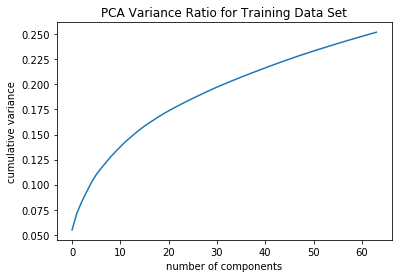

The GMM Model:  GaussianMixture(covariance_type='diag', init_params='kmeans', max_iter=100,
                means_init=None, n_components=64, n_init=1,
                precisions_init=None, random_state=None, reg_covar=1e-06,
                tol=0.001, verbose=0, verbose_interval=10, warm_start=False,
                weights_init=None)


In [81]:
#python function that computes fisher vector model
def compute_PCA_GMM_Model(training_features,label,valid_feature, test_feature):
    
    n_components = 64

    #to fit pca on the traning dataset
    pca = PCA(n_components=n_components, svd_solver='randomized', whiten=True).fit(training_features)

    # To Project the input data on pca
    traning_features_pca = pca.transform(training_features)
    valid_features_pca = pca.transform(valid_feature)
    test_features_pca = pca.transform(test_feature)

    #To plot cumulative variance corrsponding to the number of components
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('number of components')
    plt.ylabel('cumulative variance')
    plt.title( "PCA Variance Ratio for Training Data Set")
    plt.show()

    
    
    #To train GMM model on the extracted features and return gmm and features:
    gmm = GaussianMixture(n_components=64, covariance_type='diag').fit(traning_features_pca, label)
    return gmm, traning_features_pca, valid_features_pca, test_features_pca



#To call compute_PCA_GMM_Model and store features 
gmm_Model , X_training_fv, X_valid_fv, X_testing_fv= (compute_PCA_GMM_Model(X_train_data, y_train_label, X_valid_data, X_test_data))
print("The GMM Model: ", gmm_Model)

In [82]:
#Python function to compute FV aggregation
def getFisherVectorAggregation(features, gmm):
    
    
    #features = np.atleast_2d(features)
    S = features.shape[0]
    print("S=", S)

    # To get the posterior probabilities of the features
    pp = gmm.predict_proba(features)  
    print("posterior probabilities = ", pp)
    print("pp shape", pp.shape)
    # to get the sufficient statistics of descriptors.
    pp_sum = np.sum(pp, 0)[:, np.newaxis] / S
    ss1 = np.dot(pp.T, features) / S
    ss2 = np.dot(pp.T, features ** 2) / S

    # to get derivatives with respect to mixing weights, means and variances.
    d1 = pp_sum.squeeze() - gmm.weights_
    d2 = ss1 - pp_sum * gmm.means_
    d3 = (
        - ss2
        - pp_sum * gmm.means_ ** 2
        + pp_sum * gmm.covariances_
        + 2 * ss1 * gmm.means_)

    
    fv = np.hstack((d1, d2.flatten(), d3.flatten()))
    
    #fv = np.asarray((d1),np.concatenate(d2),np.concatenate(d3))
    fv = np.sqrt(abs(fv))*np.sign(fv)
    fv = fv/ np.sqrt(np.dot(fv, fv))
    return fv


#To call getFisherVectorAggregation and store fv in a list
X_Training_fv = (getFisherVectorAggregation(X_training_fv, gmm_Model))
X_Validation_fv = (getFisherVectorAggregation(X_valid_fv, gmm_Model))
X_Testing_fv = (getFisherVectorAggregation(X_testing_fv, gmm_Model)) 
#To print fv arrays shape
print("Trainig shape: ", X_Training_fv.shape)
print("Validation shape: ", X_Validation_fv.shape)
print("testing shape: ", X_Testing_fv.shape)

S= 7500
posterior probabilities =  [[0.00000000e+00 2.12712097e-09 1.70270513e-16 ... 1.90200797e-16
  0.00000000e+00 1.88807957e-12]
 [0.00000000e+00 6.45676721e-14 6.08457423e-16 ... 3.92776463e-13
  0.00000000e+00 2.92421225e-16]
 [0.00000000e+00 5.47137383e-22 1.30010201e-25 ... 6.91111935e-26
  0.00000000e+00 1.18715920e-22]
 ...
 [0.00000000e+00 1.39492548e-11 3.51627397e-08 ... 1.78499451e-23
  0.00000000e+00 7.86532782e-07]
 [0.00000000e+00 3.33436342e-05 1.32482874e-11 ... 2.44069004e-12
  0.00000000e+00 9.79338696e-10]
 [0.00000000e+00 1.79841579e-32 5.85057906e-12 ... 5.90382292e-37
  0.00000000e+00 1.08509341e-06]]
pp shape (7500, 64)
S= 1500
posterior probabilities =  [[0.00000000e+000 2.48166523e-002 1.09016434e-011 ... 3.46328244e-012
  0.00000000e+000 1.17276599e-007]
 [6.71208778e-114 1.83823073e-025 5.26080734e-039 ... 3.47166183e-037
  0.00000000e+000 6.98763169e-035]
 [0.00000000e+000 6.88286638e-013 3.13013788e-004 ... 4.41085711e-019
  0.00000000e+000 6.06645334e-

In [84]:
X_Training_fv = pd.DataFrame(X_Training_fv)
X_Validation_fv = pd.DataFrame(X_Validation_fv)
X_Testing_fv = pd.DataFrame(X_Testing_fv)

In [131]:

#To show clustring result of the aggergation vector for the training dataset 
range_n_clusters = [15, 32, 64, 128]

for n_clusters in range_n_clusters:
    
    
    clusterer = KMeans(n_clusters=n_clusters, init='k-means++', random_state=10, max_iter=300)
    cluster_labels = clusterer.fit_predict(X_Training_fv[:7500])

    silhouette_avg = silhouette_score(X_Training_fv[:7500], cluster_labels, metric='euclidean')
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

For n_clusters = 15 The average silhouette_score is : 0.5566519217646115
For n_clusters = 32 The average silhouette_score is : 0.5317053298891514
For n_clusters = 64 The average silhouette_score is : 0.5487807734158661
For n_clusters = 128 The average silhouette_score is : 0.5555572880962053


In [132]:
#To show clustring result of the aggergation vector for the training dataset on the best fit model
clusterer_15 = KMeans(n_clusters=15, init='k-means++', random_state=10, max_iter=300)
cluster_labels = clusterer_15.fit_predict(X_Training_fv[:7500])
silhouette_avg = silhouette_score(X_Training_fv[:7500], cluster_labels, metric='euclidean')
print("For n_clusters =", 15,
"The average silhouette_score is :", silhouette_avg)

For n_clusters = 15 The average silhouette_score is : 0.5566519217646115


In [133]:
#To show clustring result of the aggergation vector for the validation dataset 

cluster_labels_validation = clusterer_15.fit_predict(X_Validation_fv[:1500])
silhouette_avg_validation = silhouette_score(X_Validation_fv[:1500], cluster_labels_validation, metric='euclidean')
print("For n_clusters =", 15,
"The average silhouette_score is :", silhouette_avg_validation)

For n_clusters = 15 The average silhouette_score is : 0.5354678731655907


In [134]:
#To show clustring result of the aggergation vector for the test dataset 

cluster_labels_test = clusterer_15.fit_predict(X_Testing_fv[:1500])
silhouette_avg_test = silhouette_score(X_Testing_fv[:1500], cluster_labels_test, metric='euclidean')
print("For n_clusters =", 15,
"The average silhouette_score is :", silhouette_avg_test)

For n_clusters = 15 The average silhouette_score is : 0.5501333436445179


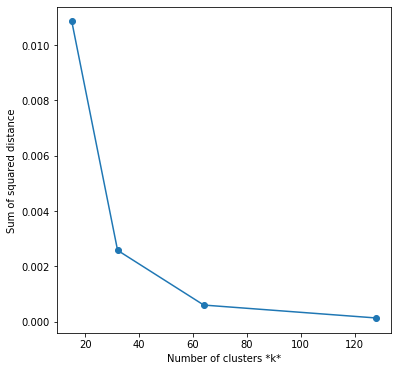

In [135]:
result= []
#To show clustring result of the aggergation vector for the training dataset 
range_n_clusters = [15, 32, 64, 128]

for n_clusters in range_n_clusters:
    km_model = KMeans(n_clusters=n_clusters)
    km_model.fit(X_Training_fv[:7500])
    result.append(km_model.inertia_)

# Plot result against k
plt.figure(figsize=(6, 6))
plt.plot(range_n_clusters, result, '-o')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance');

In [141]:
# To Train a SVM classification model
model = SVC(C=1000.0, kernel='rbf', degree=3, gamma=0.0005, coef0=0.0, shrinking=True, probability=False, tol=0.001, cache_size=200, class_weight='balanced', verbose=False, max_iter=-1, decision_function_shape='ovr', break_ties=False, random_state=None)
model = model.fit(X_training_fv, y_train_label)
print(model)

SVC(C=1000.0, break_ties=False, cache_size=200, class_weight='balanced',
    coef0=0.0, decision_function_shape='ovr', degree=3, gamma=0.0005,
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)


Validation Accuracy Score:  0.89
Predicting image class on the test set
              precision    recall  f1-score   support

           1       0.93      0.88      0.90       100
           2       0.82      0.89      0.86       100
           3       0.79      0.80      0.80       100
           4       0.75      0.80      0.78       100
           5       0.90      0.91      0.91       100
           6       0.95      0.89      0.92       100
           7       0.99      0.97      0.98       100
           8       0.82      0.77      0.79       100
           9       0.99      0.97      0.98       100
          10       0.93      0.95      0.94       100
          11       0.83      0.83      0.83       100
          12       0.91      0.91      0.91       100
          13       0.95      0.94      0.94       100
          14       0.96      0.99      0.98       100
          15       0.86      0.87      0.87       100

    accuracy                           0.89      1500
   macro

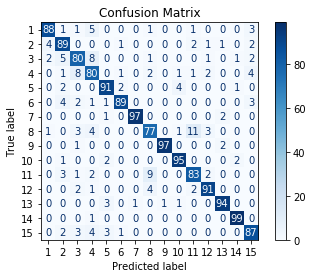

In [142]:
#To evaluate model on the validation dataset and return score:
validation_accuracy_score = model.score(X_valid_fv, y_valid_label)
print("Validation Accuracy Score: ", validation_accuracy_score)
#To predict image class on the test dataset
print("Predicting image class on the test set")

y_pred = model.predict(X_testing_fv)


print(classification_report(y_test_label, y_pred))
print(confusion_matrix(y_test_label, y_pred, labels=range(1500)))

#To plot confusion matrix

fig= plot_confusion_matrix(model, X_testing_fv, y_test_label, cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()